<div style="background-color:white;" >
<div style="clear: both; display: table;">
  <div style="float: left; width: 14%; padding: 5px; height:auto">
    <img src="img/TUBraunschweig_CO_200vH_300dpi.jpg" alt="TU_Braunschweig" style="width:100%">
  </div>
  <div style="float: left; width: 28%; padding: 5px; height:auto">
    <img src="img/TU_Clausthal_Logo.png" alt="TU_Clausthal" style="width:100%">
  </div>
  <div style="float: left; width: 25%; padding: 5px; height:auto">
    <img src="img/ostfalia.jpg" alt="Ostfalia" style="width:100%">
  </div>
  <div style="float: left; width: 21%; padding: 5px;">
    <img src="img/niedersachsen_rgb_whitebg.png" alt="Niedersachsen" style="width:100%">
  </div>
  <div style="float: left; width: 9%; padding: 5px;">
    <img src="img/internet_BMBF_gefoerdert_2017_en.jpg" alt="bmbf" style="width:100%">
  </div>
</div>
<div style="text-align:center">
<img src="img/ki4all.jpg" alt="KI4ALL-Logo" width="200"/>
</div>
</div>

# Synthetic Biomedical Data – Lesson 2b: Data Generation Basics (Part 2)

Part of the *Microcredit Artificial Data Generator* learning module.

➡️ [Back to Lesson 2a: Data Generation Basics (Part 1)](02a_data_generation_intro.ipynb)
➡️ [Module Overview (README)](../README.md)

---

*Before continuing, please make sure you have completed Lesson 2a (generation, class distribution, scatterplots).*

# Lesson 2b: Feature Distributions and Effect Size

---

### Recap from Lesson 2a
In the previous notebook, you:
- Generated a small synthetic dataset using `make_classification`.
- Inspected the **class distribution** to check balance.
- Created a **scatterplot** of two features to see if classes are separable.

This gave us a first hands-on sense of how synthetic datasets look and how separability can vary.

---

### Learning Goals for Lesson 2b
After completing this notebook, you will be able to:
1. Visualize the **class-conditional distributions** of all features.
2. Distinguish **informative** features from **irrelevant (noise)** features by inspection.
3. Quantify group differences using **effect size** measures:
   - Cohen’s d (parametric, based on means and standard deviations)
   - Cliff’s delta (non-parametric, based on ranks/overlap)
4. Relate **visual impressions** (histograms) to **numeric measures** (effect size).
5. Explain why effect size is important in biomedical research, beyond just p-values.

---

### Motivation
Looking at individual scatterplots is helpful, but real datasets often have **dozens or thousands of features**.
We need systematic ways to:
- Inspect how features are distributed across classes.
- Identify which features are informative.
- Put a **number** on the strength of class separation (effect size).

Synthetic data lets us practice these steps in a controlled environment.


### Lesson 2b.1 — Feature distributions per class

We now examine how each feature is distributed for each class:
- Are the distributions **shifted** (different means)?
- Are they **spread differently** (different variances)?
- Do some features look **uninformative** (almost identical curves)?

> **Why this matters:**
> Visual differences between class-conditional distributions often indicate **predictive signal**.
> If curves overlap almost perfectly, the feature may be **uninformative** for classification.

In [1]:
# Generate a synthetic toy dataset
from sklearn.datasets import make_classification
import pandas as pd

# Generate dataset (adjust n_features to match the number of subplots!)
X, y = make_classification(
    n_samples=30,
    n_features=8,
    n_informative=3,
    n_classes=2,
    class_sep=1.0,
    random_state=42
)

feature_names = [f"feature_{i+1}" for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df["class"] = y

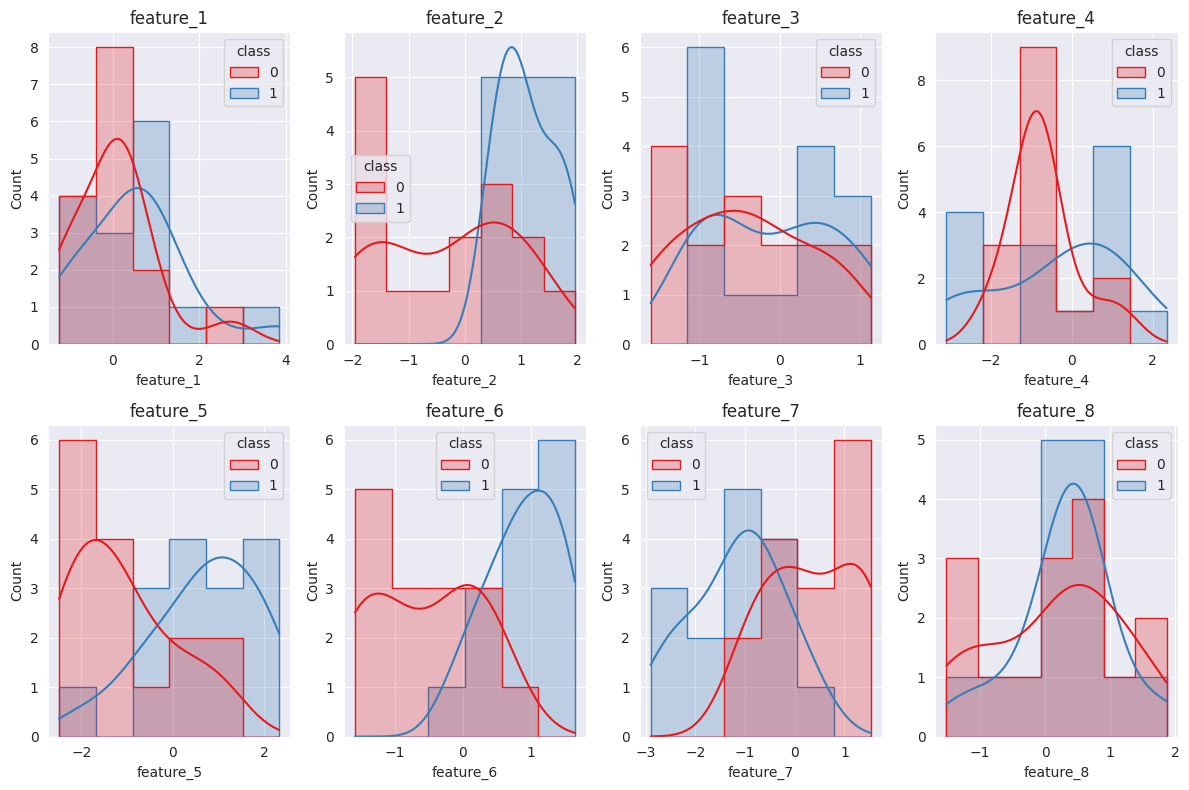

In [2]:
# Visualize feature distributions per class
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))

for i, col in enumerate(feature_names, 1):
    plt.subplot(2, 4, i)   # 2 rows, 3 columns of plots
    sns.histplot(data=df, x=col, hue="class", kde=True, element="step", palette="Set1")
    plt.title(col)

plt.tight_layout()
plt.show()

#### Interpretation & Takeaways
- Features with **clearly different** class-conditional distributions may be informative.
- Features with **almost identical** distributions across classes are likely **irrelevant** (or need interactions to show signal).
- Synthetic data is great for demonstrating both cases on purpose.

### Mini-Challenge (2–3 minutes)
Regenerate the dataset with:
- `n_informative=3`
- `class_sep=1.5`

Then re-run the scatterplot and histograms.

**Question:** Which features became more/less informative? Why?

### Lesson 2b.2 — Effect Size: Quantifying the Visual Difference

When comparing distributions between two classes, it is useful to
quantify **how large the difference is**.
This is called **effect size**.

- **Cohen’s d** measures the difference in means between two groups, scaled by their variability.
  - Small ≈ 0.2, Medium ≈ 0.5, Large ≈ 0.8.
- **Cliff’s delta** measures the proportion of non-overlap between distributions.
- These measures tell us whether a feature difference is **practically important**,
  not just statistically significant.

For example:
- A feature with almost no overlap between healthy and diseased groups
  will have a **large effect size**.
- A feature where the two distributions nearly overlap will have a **small effect size**.

---

**Reflection**
- Identify 1–2 features that look **most** and **least** informative.
  - Now, calculate their effect sizes (e.g., Cohen’s d).
  - Does the quantitative measure match your visual impression?
- What happens if you **add noise** during data generation?
  - How does the effect size change?
- How would you explain to a colleague the difference between a
  **statistically significant** result and a **large effect size**?

### Quantifying group differences with effect size

Looking at histograms is useful, but sometimes visual impressions can be misleading.
We need a **numeric measure** of how strongly two groups differ.

One common measure is **Cohen’s d**:

\[
d = \frac{\bar{x}_1 - \bar{x}_2}{s_p}
\]

where \(\bar{x}_1\) and \(\bar{x}_2\) are the means of the two groups, and \(s_p\) is the pooled standard deviation.

- **Small effect** ≈ 0.2
- **Medium effect** ≈ 0.5
- **Large effect** ≈ 0.8 or higher

By computing Cohen’s d, we can confirm whether a feature shows a **practically meaningful difference** between classes.


In [3]:
import numpy as np

# --- Function to compute Cohen's d ---
def cohens_d(x, y):
    """Compute Cohen's d for two groups."""
    nx, ny = len(x), len(y)
    dof = nx + ny - 2
    pooled_std = np.sqrt(((nx - 1) * np.var(x, ddof=1) + (ny - 1) * np.var(y, ddof=1)) / dof)
    return (np.mean(x) - np.mean(y)) / pooled_std

# --- Example: pick two features to compare between classes ---
feature_a = "feature_1"
feature_b = "feature_2"

group0_a = df.loc[df["class"] == 0, feature_a]
group1_a = df.loc[df["class"] == 1, feature_a]
group0_b = df.loc[df["class"] == 0, feature_b]
group1_b = df.loc[df["class"] == 1, feature_b]

d_a = cohens_d(group0_a, group1_a)
d_b = cohens_d(group0_b, group1_b)

print(f"Cohen's d for {feature_a}: {d_a:.2f}")
print(f"Cohen's d for {feature_b}: {d_b:.2f}")


Cohen's d for feature_1: -0.43
Cohen's d for feature_2: -1.54


#### Interpretation
- The printed values of Cohen’s d show the **magnitude of difference** between classes for each feature.
- A large value (e.g., > 0.8) means the feature strongly separates the two classes.
- A small value (close to 0) means there is almost no separation, even if the histograms looked slightly different.

**Reflection**
- Compare the numbers with the histograms you saw earlier.
  - Does a feature with large \(d\) also look well-separated visually?
  - Does a feature with small \(d\) look overlapping in the plots?
- What happens if you add **noise** during dataset generation?
  - How do the Cohen’s d values change?


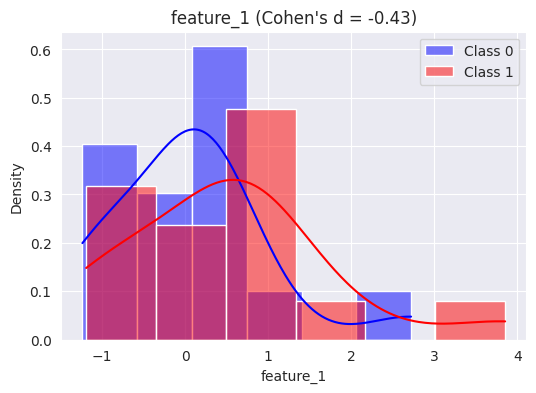

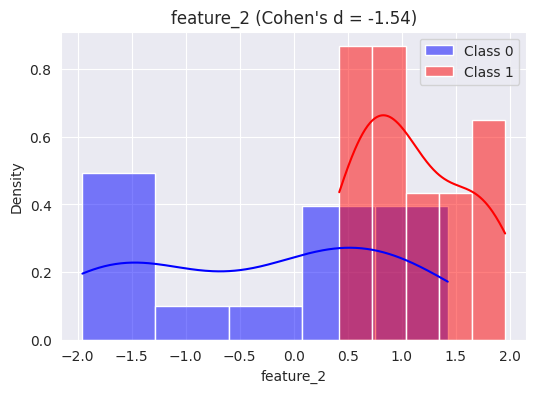

In [4]:
def plot_feature_with_d(feature_name):
    group0 = df.loc[df["class"] == 0, feature_name]
    group1 = df.loc[df["class"] == 1, feature_name]
    d = cohens_d(group0, group1)

    plt.figure(figsize=(6,4))
    sns.histplot(group0, color="blue", label="Class 0", kde=True, stat="density")
    sns.histplot(group1, color="red", label="Class 1", kde=True, stat="density")
    plt.title(f"{feature_name} (Cohen's d = {d:.2f})")
    plt.legend()
    plt.show()

plot_feature_with_d("feature_1")
plot_feature_with_d("feature_2")


#### Visualizing effect size together with distributions

The plots now show both the histogram distributions and the calculated Cohen’s d in the title.
This makes it easy to directly **connect the numeric measure to the visual impression**.

- Features with **large d** show two distributions with little overlap.
- Features with **small d** show heavy overlap between the two classes.

**Reflection**
- Do the Cohen’s d values match your intuition from the plots?
- Which feature seems the most useful for classification based on effect size?
- How might this help in **feature selection**, when many features compete for attention?


### Another measure: Cliff’s delta

Cohen’s d assumes **normally distributed data** and compares group means.
But sometimes distributions are not normal, or the means don’t capture
the important differences (e.g., skewed or heavy-tailed data).

An alternative is **Cliff’s delta (δ)**:

\[
\delta = \frac{\text{#(x > y)} - \text{#(x < y)}}{n_x \cdot n_y}
\]

- It measures how often values from one group are **larger or smaller** than values from the other group.
- Range: **-1 to +1**
  - δ = +1 → all values in group 1 > group 2
  - δ = -1 → all values in group 1 < group 2
  - δ = 0 → complete overlap (no difference)

This is a **non-parametric effect size**: it does not assume normality.


In [5]:
def cliffs_delta(x, y):
    """Compute Cliff's delta for two groups."""
    nx, ny = len(x), len(y)
    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)
    delta = (greater - less) / (nx * ny)
    return delta

# Example: compute Cliff's delta for two features
delta_a = cliffs_delta(group0_a, group1_a)
delta_b = cliffs_delta(group0_b, group1_b)

print(f"Cliff's delta for {feature_a}: {delta_a:.2f}")
print(f"Cliff's delta for {feature_b}: {delta_b:.2f}")


Cliff's delta for feature_1: -0.36
Cliff's delta for feature_2: -0.71


#### Interpretation
- Cliff’s delta values closer to **±1** indicate strong separation between groups.
- Values near **0** mean the two groups overlap heavily.
- Positive δ means group 1 tends to have larger values; negative δ means group 2 tends to have larger values.

**Reflection**
- Compare Cohen’s d and Cliff’s delta for the same features:
  - Do they agree on which feature is most informative?
  - Which measure do you prefer if the distributions are skewed?
- Try computing Cliff’s delta on a feature with heavy overlap — does it confirm your visual impression?


### Quick Takeaway from Lesson 2
- We can easily generate a synthetic dataset with controlled samples, features, and classes.
- Visual exploration (scatterplots, histograms) helps us identify which features separate classes well and which do not.
- Not all features are informative — some behave like noise and add no predictive value.
- Effect size (e.g., Cohen’s d, Cliff’s delta) provides a **numeric measure** of how strongly two groups differ, complementing what we see in the plots.
- These simple datasets give us a safe playground to understand the basics before moving to more complex cases (irrelevant features, correlations, pseudo-classes, and random effects).